In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from pyproj import CRS, Transformer
import xarray as xr
from sklearn.cross_decomposition import PLSRegression


In [3]:
env_filepath = '/cluster/home/maikents/coral-mapping/processed_data/env_df_no_nan.parquet'
env_df = pd.read_parquet(env_filepath)

In [4]:
coral_filepath = '/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/midnor_total_coral_data_filtered_UTM32N.parquet'
coral_df = pd.read_parquet(coral_filepath)

In [5]:
#Clean env_data
env_df = env_df.drop(columns=['stat_mean','spatial_ref_mean'])

In [89]:
#print(env_df.columns)

In [15]:
env_df['label'] = 0


100128072


In [ ]:
env_df['x'].min

In [65]:
#100: 718
#200: 718
#300: 718
search_radiuses = [100]
counts = []
env_df_copy = env_df.copy(deep=True)

env_df['x_rounded'] = env_df['x'].round()
env_df['y_rounded'] = env_df['y'].round()

coral_df['x_rounded'] = coral_df['x'].round()
coral_df['y_rounded'] = coral_df['y'].round()

for radius in search_radiuses:    
      
    for idx, row in coral_df.iterrows():
        x, y = row['x_rounded'], row['y_rounded']
    
        distances = np.sqrt((env_df_copy['x_rounded'] - x)**2 + (env_df_copy['y_rounded'] - y)**2)
    
        nearest_idx = distances[distances <= radius].idxmin() if not distances[distances <= radius].empty else None
    
        if nearest_idx is not None:
            env_df.at[nearest_idx, 'label'] = 1
        num_ones = env_df_copy['label'].sum()
    counts.append(num_ones)



In [66]:
print(env_df['label'].sum())

718


In [68]:
print(env_df.columns)

Index(['x', 'y', 'bottom_temperature_features', 'bottom_salinity_features',
       'bottom_current_features', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_temperature_features_mean', 'bottom_salinity_features_mean',
       'bottom_current_features_mean',
       'bottom_statistical_northness_features_mean',
       'bottom_statistical_eastness_features_mean',
       'bottom_temperature_features_10th_percentile',
       'bottom_salinity_features_10th_percentile',
       'bottom_current_features_10th_percentile',
       'bottom_temperature_features_90th_percentile',
       'bottom_salinity_features_90th_percentile',
       'bottom_current_features_90th_percentile', 'label', 'x_rounded',
       'y_rounded', '_merge'],
      dtype='object')


In [69]:
env_df = env_df.drop(columns=['y_rounded','x_rounded'])

In [67]:
emod_filepath = '/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/EMOD_features.nc'
EMOD_features = xr.open_dataset(emod_filepath)

In [71]:
print(list(EMOD_features.variables))

['x', 'y', 'aspect_cos_clipped', 'aspect_sin_clipped', 'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped', 'fine_BPI_std_clipped', 'log_ruggedness_1_clipped', 'slope_clipped']


In [73]:
emod_df = EMOD_features[['x', 'y', 'aspect_cos_clipped', 'aspect_sin_clipped', 'bathymetry_32N_Clip_sample_clipped',
                        'broad_BPI_std_clipped', 'fine_BPI_std_clipped', 'log_ruggedness_1_clipped', 'slope_clipped']].to_dataframe().reset_index()


(80511075, 9)
(100128072, 21)


In [85]:
emod_df = emod_df.dropna(axis=0)
env_df = env_df.dropna(axis=0)

In [ ]:
scaler = StandardScaler()
features_to_scale = [
    'aspect_cos_clipped',
    'aspect_sin_clipped',
    'bathymetry_32N_Clip_sample_clipped',
    'broad_BPI_std_clipped',
    'fine_BPI_std_clipped', 
    'log_ruggedness_1_clipped', 
    'slope_clipped'
]
scaled_emod_data = scaler.fit_transform(emod_df[features_to_scale])
emod_df[features_to_scale] = scaled_emod_data

print(env_df.head())


In [92]:
merged_df = pd.merge(env_df, emod_df, on=['x', 'y'], how='outer')

print(merged_df.columns)

Index(['x', 'y', 'bottom_temperature_features', 'bottom_salinity_features',
       'bottom_current_features', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_temperature_features_mean', 'bottom_salinity_features_mean',
       'bottom_current_features_mean',
       'bottom_statistical_northness_features_mean',
       'bottom_statistical_eastness_features_mean',
       'bottom_temperature_features_10th_percentile',
       'bottom_salinity_features_10th_percentile',
       'bottom_current_features_10th_percentile',
       'bottom_temperature_features_90th_percentile',
       'bottom_salinity_features_90th_percentile',
       'bottom_current_features_90th_percentile', 'label', '_merge',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'log_ruggedness_1_clipped', 'slope_clipped'],
      dtype='object')


In [96]:
#PLS:

X = merged_df[['bottom_temperature_features', 'bottom_salinity_features',
       'bottom_current_features', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_temperature_features_mean', 'bottom_salinity_features_mean',
       'bottom_current_features_mean',
       'bottom_statistical_northness_features_mean',
       'bottom_statistical_eastness_features_mean',
       'bottom_temperature_features_10th_percentile',
       'bottom_salinity_features_10th_percentile',
       'bottom_current_features_10th_percentile',
       'bottom_temperature_features_90th_percentile',
       'bottom_salinity_features_90th_percentile',
       'bottom_current_features_90th_percentile',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'log_ruggedness_1_clipped', 'slope_clipped']]

y = merged_df[['label']]
print(X.columns)
print(y.columns)
print(merged_df.columns)

Index(['bottom_temperature_features', 'bottom_salinity_features',
       'bottom_current_features', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_temperature_features_mean', 'bottom_salinity_features_mean',
       'bottom_current_features_mean',
       'bottom_statistical_northness_features_mean',
       'bottom_statistical_eastness_features_mean',
       'bottom_temperature_features_10th_percentile',
       'bottom_salinity_features_10th_percentile',
       'bottom_current_features_10th_percentile',
       'bottom_temperature_features_90th_percentile',
       'bottom_salinity_features_90th_percentile',
       'bottom_current_features_90th_percentile', 'aspect_cos_clipped',
       'aspect_sin_clipped', 'bathymetry_32N_Clip_sample_clipped',
       'broad_BPI_std_clipped', 'fine_BPI_std_clipped',
       'log_ruggedness_1_clipped', 'slope_clipped'],
      dtype='object')
Index(['label'], dtype='object')
Index

In [97]:
final_merged_df = merged_df[['x', 'y',
       'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean',
       'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile',
       'label','aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped']]

In [98]:
final_merged_df.to_parquet('/cluster/home/maikents/coral-mapping/processed_data/df_ready_for_training.parquet')


In [2]:
merged_df_file = '/cluster/home/maikents/coral-mapping/processed_data/df_ready_for_training.parquet'
merged_df = pd.read_parquet(merged_df_file)

In [3]:
print(merged_df.columns)

Index(['x', 'y', 'bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean', 'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile', 'label',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped'],
      dtype='object')


In [4]:
X = merged_df[['bottom_statistical_northness_features',
       'bottom_statistical_eastness_features', 'current_aspect_angle',
       'bottom_salinity_features_mean', 'bottom_current_features_mean',
       'bottom_temperature_features_10th_percentile',
       'aspect_cos_clipped', 'aspect_sin_clipped',
       'bathymetry_32N_Clip_sample_clipped', 'broad_BPI_std_clipped',
       'fine_BPI_std_clipped', 'slope_clipped']]
y = merged_df[['label']]

In [5]:
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split 

In [6]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, Y_train)

PLSRegression()

In [19]:
X_scores, Y_scores = pls.transform(X_train), pls.predict(X_train)


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


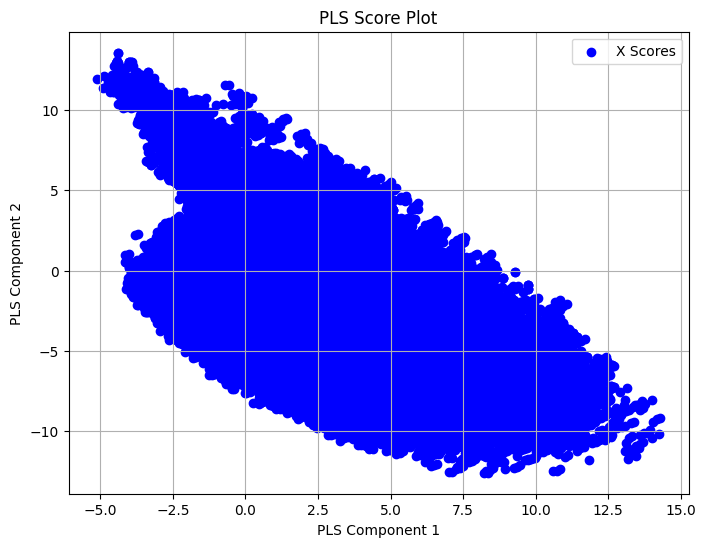

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scores[:, 0], X_scores[:, 1], c='b', label='X Scores')
plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("PLS Score Plot")
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Predictions
Y_train_pred = pls.predict(X_train)
Y_test_pred = pls.predict(X_test)

# Explained variance
print("X Loadings:", pls.x_loadings_)
print("Y Loadings:", pls.y_loadings_)



X Loadings: [[ 0.08001637  0.16084068]
 [ 0.05835076  0.03635853]
 [-0.01266508 -0.05065122]
 [ 0.03738774 -0.32556931]
 [ 0.1219858  -0.33357691]
 [ 0.66842424  0.26884807]
 [-0.34251279  0.34933973]
 [ 0.11599332  0.50596066]
 [ 0.63962692  0.42149726]
 [ 0.09600884  0.20179331]
 [ 0.12627826 -0.01397626]
 [ 0.20639165 -0.41017808]]
Y Loadings: [[ 0.00212137 -0.0012798 ]]


In [9]:

from sklearn.metrics import mean_squared_error, r2_score

print(f"Train MSE: {mean_squared_error(Y_train, Y_train_pred)}")
print(f"Test MSE: {mean_squared_error(Y_test, Y_test_pred)}")
print(f"Train R^2: {r2_score(Y_train, Y_train_pred)}")
print(f"Test R^2: {r2_score(Y_test, Y_test_pred)}")

Train MSE: 7.253092880476349e-06
Test MSE: 6.8411361980942085e-06
Train R^2: 8.99371269791338e-06
Test R^2: 8.051768876637944e-06


In [25]:
print(X.columns)


X = X.rename(columns={'bottom_statistical_northness_features':'statistical northness',
       'bottom_statistical_eastness_features': 'statistical eastness', 'current_aspect_angle': 'current aspect angle',
       'bottom_salinity_features_mean': 'salinity mean', 'bottom_current_features_mean': 'current speed mean',
       'bottom_temperature_features_10th_percentile':'temperature min', 'aspect_cos_clipped': 'aspect cos',
       'aspect_sin_clipped': 'aspect sin', 'bathymetry_32N_Clip_sample_clipped': 'bathymetry 32N' ,
       'broad_BPI_std_clipped': 'broad BPI std', 'fine_BPI_std_clipped': 'fine BPI std', 'slope_clipped': 'slope'})


Index(['statistical northness', 'statistical eastness', 'current aspect angle',
       'salinity mean', 'current speed mean', 'temperature min', 'aspect cos',
       'aspect sin', 'bathymetry 32N', 'broad BPI std', 'fine BPI std',
       'slope'],
      dtype='object')


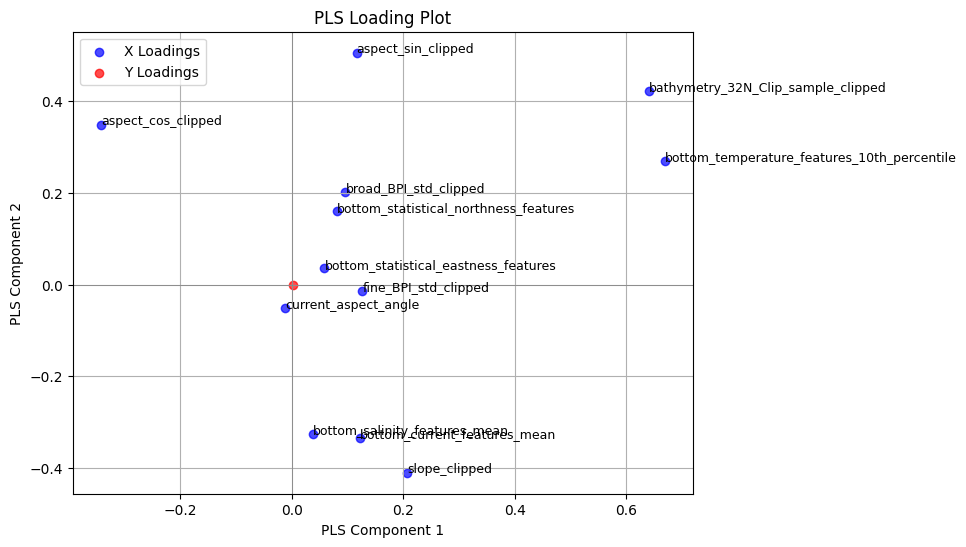

In [26]:

loadings_X = pls.x_loadings_
loadings_Y = pls.y_loadings_

plt.figure(figsize=(8, 6))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)


for i, feature in enumerate(X_train.columns):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], feature, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("PLS Loading Plot")
plt.grid(True)
plt.legend()
plt.show()

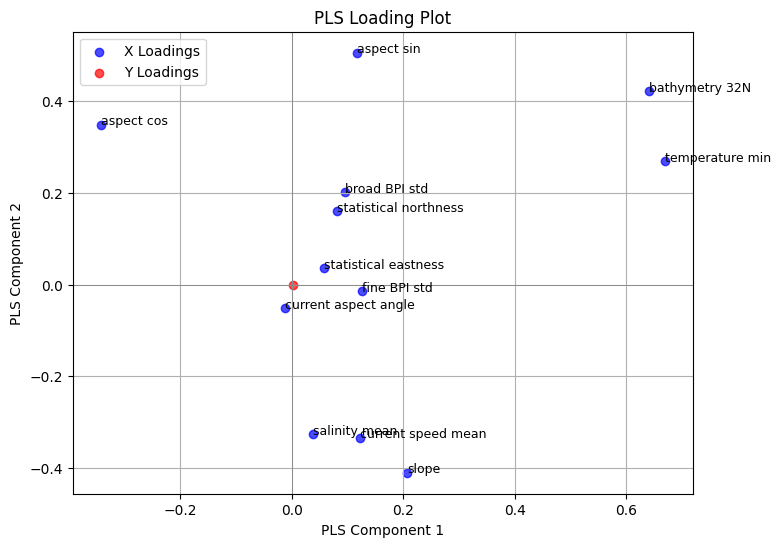

In [32]:

custom_labels = ['statistical northness', 'statistical eastness', 'current aspect angle','salinity mean',
                 'current speed mean', 'temperature min', 'aspect cos', 'aspect sin', 'bathymetry 32N', 'broad BPI std',
                'fine BPI std', 'slope']


plt.figure(figsize=(8, 6))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)


for i, label in enumerate(custom_labels):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], label, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("PLS Loading Plot")
plt.grid(True)
plt.legend()
plt.show()


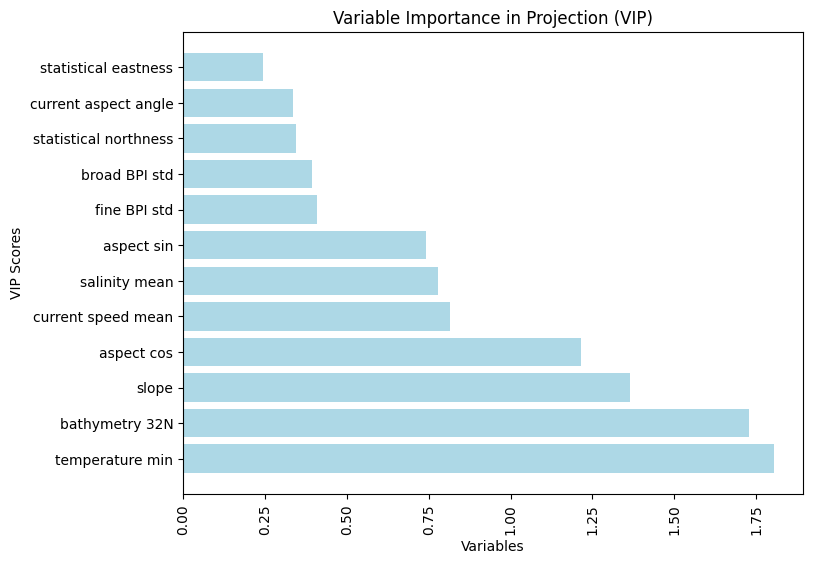

In [36]:
W = pls.x_weights_ 
T = pls.x_scores_   

explained_variance = np.var(T, axis=0) / np.sum(np.var(T, axis=0))

vip_scores = np.sqrt(X_train.shape[1] * np.sum((W**2) * explained_variance, axis=1))

vip_df = pd.DataFrame({
    'Variable': X_train.columns,  # Feature names
    'VIP Score': vip_scores
})
custom_labels = ['Feature 1', 'Feature 2', 'Feature 3', ...]
vip_df['Variable'] = ['statistical northness', 'statistical eastness', 'current aspect angle','salinity mean',
                 'current speed mean', 'temperature min', 'aspect cos', 'aspect sin', 'bathymetry 32N', 'broad BPI std',
                'fine BPI std', 'slope']

vip_df = vip_df.sort_values(by='VIP Score', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(vip_df['Variable'], vip_df['VIP Score'], color='lightblue')  
plt.title("Variable Importance in Projection (VIP)")
plt.xlabel("Variables")
plt.ylabel("VIP Scores")
plt.xticks(rotation=90)
plt.show()

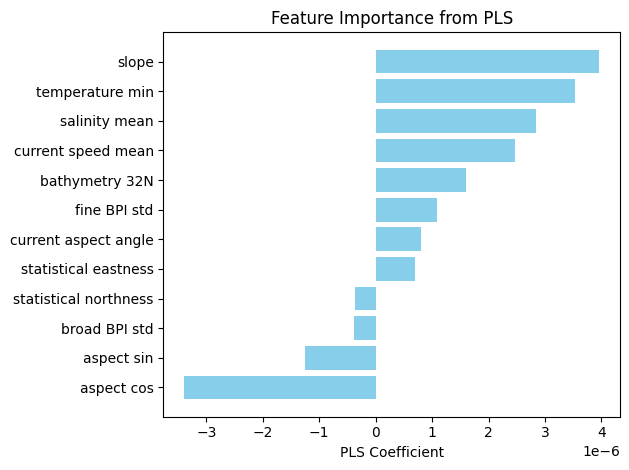

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and corresponding coefficients
features = X.columns
coefficients = pls.coef_.ravel()

# Sort features by importance
sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Create a horizontal bar plot
plt.barh(sorted_features, sorted_coefficients, color="skyblue")
plt.title("Feature Importance from PLS")
plt.xlabel("PLS Coefficient")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()  # Ensure everything fits
plt.show()